In [917]:
import jax.numpy as jnp
import jax
import optax

import numpy as np

import matplotlib.pyplot as plt

In [918]:
from time import sleep

In [953]:
from functools import partial

In [919]:
from tqdm.notebook import trange, tqdm

In [920]:
from typing import Dict

In [921]:
seed_fn = lambda : np.random.randint(0, 1e6)

In [922]:
seed_fn()

661925

In [923]:
input_units = 1
units = 2
# units = 200
output_units = 1
initial_params = {
    'w1':jax.random.normal(shape=[input_units, units], key=jax.random.PRNGKey(seed_fn())),
    'w2':jax.random.normal(shape=[units, units], key=jax.random.PRNGKey(seed_fn())),
    'w3':jax.random.normal(shape=[units, output_units], key=jax.random.PRNGKey(seed_fn())),
    
    'b1':jax.random.normal(shape=[units,], key=jax.random.PRNGKey(seed_fn())),
    'b2':jax.random.normal(shape=[units,], key=jax.random.PRNGKey(seed_fn())),
    'b3':jax.random.normal(shape=[output_units,], key=jax.random.PRNGKey(seed_fn())),
}

In [924]:
def ann(x: jnp.ndarray, params: Dict) -> jnp.ndarray:
    x = jnp.dot(x, params['w1']) + params['b1']
    # x = jax.nn.relu(x)
    # x = jnp.sin(x)
    # x = jnp.tanh(x)
    x = jax.nn.sigmoid(x)
    x = jnp.dot(x, params['w2']) + params['b2']
    # x = jax.nn.relu(x)
    # x = jnp.sin(x)
    # x = jnp.tanh(x)
    x = jax.nn.sigmoid(x)
    x = jnp.dot(x, params['w3']) + params['b3']
    return x

In [925]:
x = np.arange(0, 1, 0.01)[:,np.newaxis]
# x_fine = np.arange(-0.1, 1.1, 0.001)[:,np.newaxis]
x_fine = np.arange(0, 1., 0.001)[:,np.newaxis]

In [926]:
ann(x, initial_params).shape

(100, 1)

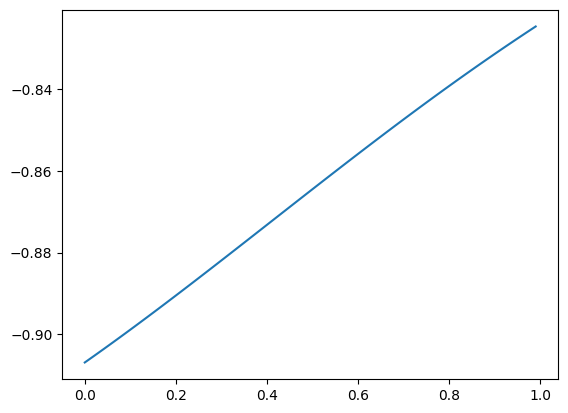

In [927]:
plt.plot(x, ann(x, initial_params))

In [928]:
def gen_data():
    n_samples = 100
    x = np.random.uniform(0, 1, n_samples)[:,np.newaxis]
    # y = x * np.sin(x/0.3)
    y = x * np.sin(x/0.1)
    
    # y[0] = 2
    
    return x, y

In [929]:
X, y = gen_data()

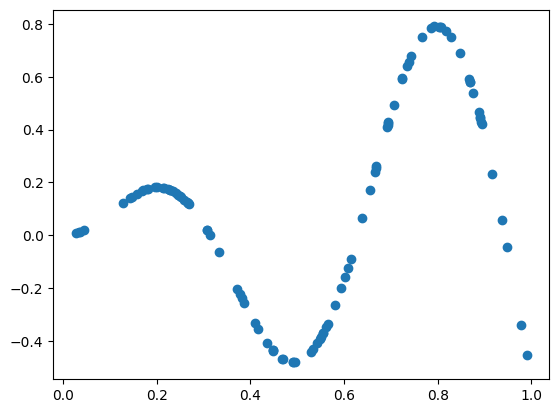

In [930]:
plt.plot(X, y, 'o')
# plt.plot(X, ann(X, initial_params), 'o')

In [994]:
# @partial(jax.jit, static_argnames=['model'])

# note here that we use the global model variable `ann`

def loss_fn(params, X, y):
    yhat = ann(X, params)
    loss_value = (y - yhat)**2
    return loss_value.mean()

In [995]:
loss_fn(initial_params, X, y)

Array(1.0881037, dtype=float32)

In [996]:
def fit(params, optimizer):
    epochs = 100000
    every = epochs//100
    losses = []
    opt_state = optimizer.init(params)
    model = ann
    
    @jax.jit
    # @partial(jax.jit, static_argnames=['model'])
    # @partial(jax.jit, static_argnums=(0,))
    def step(params, opt_state, X, y):
        loss_value, grads = jax.value_and_grad(loss_fn)(params, X, y)
        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        return params, opt_state, loss_value
    
    
    # https://stackoverflow.com/questions/37506645/can-i-add-message-to-the-tqdm-progressbar
    loop_obj = tqdm(np.arange(epochs))

    # for i in trange(100):
    for i in loop_obj:
        params, opt_state, loss_value = step(params, opt_state, X, y)
        losses.append(loss_value)
        if i % every == 0:
            loop_obj.set_description(f"Epoch: {i}")  # Adds text before progessbar
            loop_obj.set_postfix_str(f"Loss: {loss_value:,.3e}")  # Adds text after progressbar
        
    return params, np.array(losses)

In [997]:
initial_params

{'w1': Array([[-0.46714202, -1.5239668 ]], dtype=float32),
 'w2': Array([[ 1.3305558 , -0.9200362 ],
        [ 2.3022597 ,  0.43542898]], dtype=float32),
 'w3': Array([[-1.3202399 ],
        [-0.39146256]], dtype=float32),
 'b1': Array([-0.2453117 , -0.38291442], dtype=float32),
 'b2': Array([ 1.2534554, -0.0647466], dtype=float32),
 'b3': Array([0.5028974], dtype=float32)}

In [998]:
ann

<function __main__.ann(x: jax.Array, params: Dict) -> jax.Array>

In [999]:
optimizer = optax.adam(learning_rate=1e-3)
params, losses = fit(initial_params, optimizer)

  0%|          | 0/100000 [00:00<?, ?it/s]

In [1000]:
params

{'b1': Array([0.15677884, 4.1209292 ], dtype=float32),
 'b2': Array([-9.72006  , -2.3996832], dtype=float32),
 'b3': Array([-4.942961], dtype=float32),
 'w1': Array([[-6.9926834, -4.2142773]], dtype=float32),
 'w2': Array([[ 5.244306 , 13.544093 ],
        [11.784603 ,  3.6450357]], dtype=float32),
 'w3': Array([[-8.316789],
        [13.174159]], dtype=float32)}

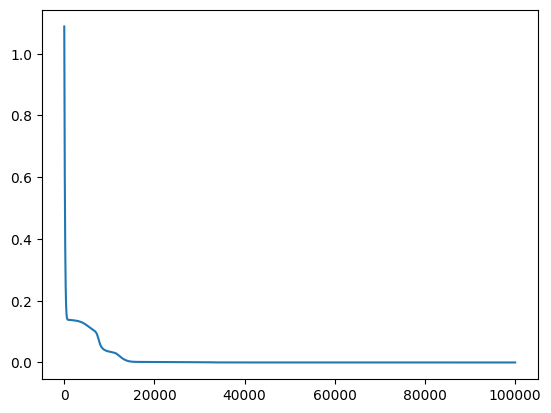

In [1001]:
plt.plot(losses)

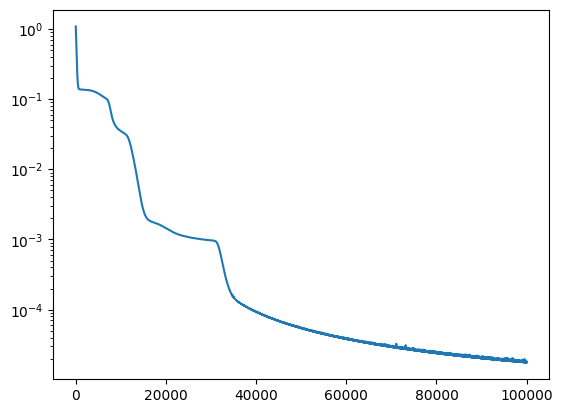

In [1002]:
plt.plot(losses)
plt.yscale('log')

In [1003]:
yhat = ann(X, params)

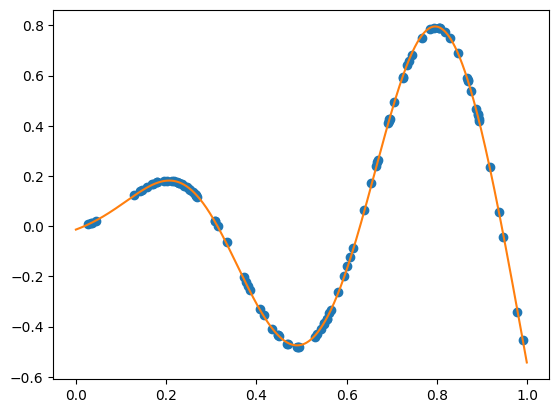

In [1004]:
plt.plot(X, y, 'o')
# plt.plot(X, ann(X, initial_params), 'o')
plt.plot(x_fine, ann(x_fine, params), '-')

In [1005]:
jax.grad(loss_fn)(initial_params, X, y)

{'b1': Array([0.02661 , 0.097615], dtype=float32),
 'b2': Array([0.21535937, 0.18626118], dtype=float32),
 'b3': Array([-1.9490974], dtype=float32),
 'w1': Array([[0.0175746, 0.0516244]], dtype=float32),
 'w2': Array([[0.08023047, 0.07037908],
        [0.04817467, 0.04414603]], dtype=float32),
 'w3': Array([[-1.768673 ],
        [-0.8250801]], dtype=float32)}

In [1006]:
jax.value_and_grad(loss_fn)(initial_params, X, y)

(Array(1.0881037, dtype=float32),
 {'b1': Array([0.02661 , 0.097615], dtype=float32),
  'b2': Array([0.21535937, 0.18626118], dtype=float32),
  'b3': Array([-1.9490974], dtype=float32),
  'w1': Array([[0.0175746, 0.0516244]], dtype=float32),
  'w2': Array([[0.08023047, 0.07037908],
         [0.04817467, 0.04414603]], dtype=float32),
  'w3': Array([[-1.768673 ],
         [-0.8250801]], dtype=float32)})

In [1007]:
# the trained network
# shows that the grad i.e. change in parameters
# is small.
# i.e. in a minimum
jax.value_and_grad(loss_fn)(params, X, y)

(Array(1.7641965e-05, dtype=float32),
 {'b1': Array([ 3.9425213e-06, -8.8330125e-06], dtype=float32),
  'b2': Array([-1.1465425e-05,  2.3692082e-05], dtype=float32),
  'b3': Array([1.2815304e-05], dtype=float32),
  'w1': Array([[ 1.6293204e-06, -6.9348330e-06]], dtype=float32),
  'w2': Array([[-1.9384132e-07,  1.1331672e-06],
         [-1.4066661e-05,  1.6772754e-05]], dtype=float32),
  'w3': Array([[8.475787e-06],
         [8.166999e-07]], dtype=float32)})